# Zillow Real Estate Time Series Analysis 

## 1. Business Use Case and Project Overview 

Our client has hired us to analize data from all over the State of New York to determine which five metro areas are the best choice for real estate investment. Our data comes from zillow, and tracks the median home price for many of the country's major metro areas. These metro areas are denoted by zillows internal 'Msa' designation, which stands for 'Metropolitan Statistical Area', meaning there are more than 50,000 people living in an urbanized area. 

## 2. Exploratory Data Analysis and Data Preparation

### 2.1 Importing the Necessary Libraries and packages

In [1]:
# Importing the relevant packages and libraries 
import numpy as np 
e = np.e
import pandas as pd 
import matplotlib
import statsmodels.api as sm 
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import warnings
warnings.filterwarnings('ignore')

### 2.2 Importing the Zillow Data as a Pandas Dataframe

In [2]:
# Importing the data from the csv 
df = pd.read_csv('Data/zillow_metro_areas.csv')

# Taking a look at the shape of the dataset
print(df.shape)

# This line will tell us how many of our rows represent metro areas
print(df.RegionType.value_counts())

# Examining the first five rows of our dataframe
df.head()

(909, 266)
Msa        908
Country      1
Name: RegionType, dtype: int64


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
0,102001,0,United States,Country,NaN,127569.0,127914.0,128277.0,129016.0,129762.0,...,269165.0,272132.0,275247.0,278593.0,282335.0,286913.0,292304.0,298069.0,303296.0,308220.0
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
2,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,231209.0,232014.0,233247.0,235592.0,238105.0,...,736123.0,741232.0,748830.0,756443.0,767598.0,783132.0,803315.0,824025.0,837548.0,846526.0
3,394463,3,"Chicago, IL",Msa,IL,170602.0,171004.0,171525.0,172568.0,173673.0,...,257432.0,258905.0,261216.0,263319.0,266367.0,269105.0,272894.0,277086.0,281183.0,284285.0
4,394514,4,"Dallas-Fort Worth, TX",Msa,TX,130189.0,130293.0,130379.0,130591.0,130813.0,...,274646.0,276926.0,280361.0,284368.0,289886.0,296250.0,303499.0,311268.0,319368.0,326597.0


So in the raw dataframe, we have 909 rows, with 266 columns. Of those 266 columns, 5 of them describe the metro area represented by each row. Columns 6 through 266 represent a time series that spans from January of 2000, to September of 2021. The values are the median home price for that metro area on that specific month. 

Of our 909 rows, the first is the only row that represents a region other than a metro area, it tracks the median home price for the entire US. 

### 2.3 Filtering by NY

Our client only operates within New York State, so we need to filter down our raw dataframe to only look at metro area where 'NY' is designated for the StateName column. 

In [3]:
# Making a dataframe of just New York
df_ny = df[df['StateName'] == 'NY']

# Seeing how many rows we get 
print(df_ny.shape)

# Sanity check 
df_ny.head()

(26, 266)


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
47,394425,47,"Buffalo, NY",Msa,NY,93968.0,94487.0,94871.0,95602.0,96126.0,...,194644.0,197043.0,199299.0,201195.0,203599.0,NaN,214992.0,221501.0,224418.0,225838.0
51,395031,51,"Rochester, NY",Msa,NY,100972.0,100678.0,100670.0,100915.0,101426.0,...,173209.0,174585.0,176320.0,178740.0,181365.0,184705.0,188451.0,192158.0,194050.0,194732.0
60,394308,60,"Albany, NY",Msa,NY,108218.0,108769.0,109063.0,109786.0,110293.0,...,221148.0,223755.0,227379.0,230181.0,232777.0,234700.0,238043.0,241724.0,245616.0,248417.0
79,395143,79,"Syracuse, NY",Msa,NY,83512.0,83785.0,84042.0,84537.0,85003.0,...,161572.0,162944.0,164817.0,165917.0,167891.0,169984.0,172904.0,175277.0,177040.0,178075.0


So after filtering our dataframe down, we are left with 26 metro areas throughout NY state. 

### 2.4 Checking for NaN values

In [4]:
# Checking our dataframe for NaN values
print(f'There are {df_ny.isna().sum().sum()} NaNs in our original dataframe')

# Backfilling that single NaN
df_ny.fillna(method='bfill', inplace=True)

# Sanity check
print(f'There are {df_ny.isna().sum().sum()} NaNs after using backfill')

There are 1 NaNs in our original dataframe
There are 0 NaNs after using backfill


Okay so in our entire dataframe we had a single Nan value we have to deal with, and because this is a time series, we used a backfill technique to deal with it. 

### 2.5 Price Distribution Within New York State

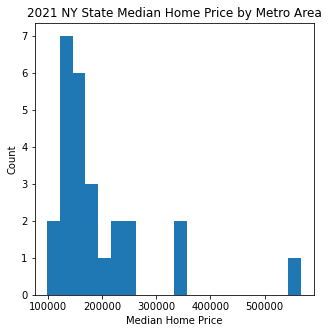

In [5]:
current_median_msa_home_prices = list(df_ny['2021-09-30'])

fig, ax = plt.subplots(figsize=(5,5))
plt.hist(current_median_msa_home_prices, bins=20)
plt.title('2021 NY State Median Home Price by Metro Area')
plt.xlabel('Median Home Price')
plt.ylabel('Count')
plt.show()

Okay so we have one significant outlier, which is guaranteed to be the NYC metro area, which we confirm below. However this does not necessarily mean that NYC is the best choice for investment, as our models may predict. 

In [6]:
# Checking the median home price for New York in the most recent month. 
int(df_ny[df_ny['RegionName'] == 'New York, NY']['2021-09-30'])

567059

In [7]:
df_ny.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
47,394425,47,"Buffalo, NY",Msa,NY,93968.0,94487.0,94871.0,95602.0,96126.0,...,194644.0,197043.0,199299.0,201195.0,203599.0,184705.0,214992.0,221501.0,224418.0,225838.0
51,395031,51,"Rochester, NY",Msa,NY,100972.0,100678.0,100670.0,100915.0,101426.0,...,173209.0,174585.0,176320.0,178740.0,181365.0,184705.0,188451.0,192158.0,194050.0,194732.0
60,394308,60,"Albany, NY",Msa,NY,108218.0,108769.0,109063.0,109786.0,110293.0,...,221148.0,223755.0,227379.0,230181.0,232777.0,234700.0,238043.0,241724.0,245616.0,248417.0
79,395143,79,"Syracuse, NY",Msa,NY,83512.0,83785.0,84042.0,84537.0,85003.0,...,161572.0,162944.0,164817.0,165917.0,167891.0,169984.0,172904.0,175277.0,177040.0,178075.0


In [8]:
df_ny.shape

(26, 266)

### 2.5 Melt Data Function 

In [9]:
# This function was provided for us with the dataset at the beginning of this project
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    melted = pd.melt(df, id_vars=['RegionID', 'SizeRank', 'RegionName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

### 2.6 Time Series for all of New York State

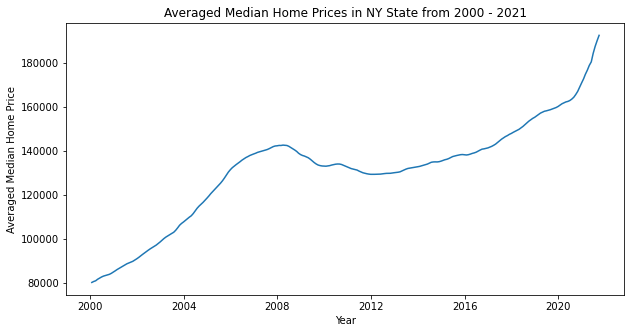

In [10]:
# Melting the New York dataframe
df_ny_melted = melt_data(df_ny)

# Plotting the average time series for all of NY state
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(df_ny_melted)
plt.title('Averaged Median Home Prices in NY State from 2000 - 2021')
plt.xlabel('Year')
plt.ylabel('Averaged Median Home Price');

In [11]:
df_ny.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30
1,394913,1,"New York, NY",Msa,NY,225438.0,226785.0,227997.0,230383.0,232604.0,...,514350.0,519193.0,523962.0,528241.0,532983.0,538439.0,545638.0,553551.0,561136.0,567059.0
47,394425,47,"Buffalo, NY",Msa,NY,93968.0,94487.0,94871.0,95602.0,96126.0,...,194644.0,197043.0,199299.0,201195.0,203599.0,184705.0,214992.0,221501.0,224418.0,225838.0
51,395031,51,"Rochester, NY",Msa,NY,100972.0,100678.0,100670.0,100915.0,101426.0,...,173209.0,174585.0,176320.0,178740.0,181365.0,184705.0,188451.0,192158.0,194050.0,194732.0
60,394308,60,"Albany, NY",Msa,NY,108218.0,108769.0,109063.0,109786.0,110293.0,...,221148.0,223755.0,227379.0,230181.0,232777.0,234700.0,238043.0,241724.0,245616.0,248417.0
79,395143,79,"Syracuse, NY",Msa,NY,83512.0,83785.0,84042.0,84537.0,85003.0,...,161572.0,162944.0,164817.0,165917.0,167891.0,169984.0,172904.0,175277.0,177040.0,178075.0


### 2.7 Reshaping the Dataframe

Our data is currently stored in 'wide format' and for our time series models to run, we need to convert our data into 'long format' where the values are stored vertically. 

In [26]:
# This cell came courtesy of the other group working on this project 
df = pd.DataFrame()
for i in df_ny['RegionName']:
    x = melt_data(df_ny[df_ny['RegionName'] == i])
    df = pd.concat([df, x], axis=1)
    df.rename(columns = {'value':i}, inplace = True)
    
df

,"New York, NY","Buffalo, NY","Rochester, NY","Albany, NY","Syracuse, NY","Utica, NY","Binghamton, NY","Kingston, NY","Jamestown, NY","Glens Falls, NY",...,"Olean, NY","Auburn, NY","Hudson, NY","Oneonta, NY","Batavia, NY","Gloversville, NY","Malone, NY","Amsterdam, NY","Cortland, NY","Seneca Falls, NY"
time,,,,,,,,,,,,,,,,,,,,,
2000-01-31,225438.0,93968.0,100972.0,108218.0,83512.0,70873.0,72439.0,121457.0,62578.0,81455.0,...,65392.0,65192.0,107100.0,52148.0,78239.0,52944.0,51026.0,55597.0,58478.0,64062.0
2000-02-29,226785.0,94487.0,100678.0,108769.0,83785.0,71222.0,72755.0,122299.0,62985.0,81910.0,...,65820.0,65649.0,107846.0,52461.0,78651.0,53187.0,51537.0,55792.0,58825.0,64325.0
2000-03-31,227997.0,94871.0,100670.0,109063.0,84042.0,71484.0,73045.0,123132.0,63161.0,82210.0,...,66097.0,65980.0,108273.0,52647.0,78923.0,53357.0,51772.0,55943.0,59093.0,64720.0
2000-04-30,230383.0,95602.0,100915.0,109786.0,84537.0,72079.0,73541.0,124778.0,63579.0,82875.0,...,66715.0,66634.0,109224.0,52997.0,79398.0,53789.0,52407.0,56338.0,59571.0,65382.0
2000-05-31,232604.0,96126.0,101426.0,110293.0,85003.0,72541.0,73906.0,126087.0,63794.0,83362.0,...,67193.0,67085.0,109909.0,53369.0,79749.0,54076.0,52735.0,56838.0,59991.0,65927.0
2000-06-30,234969.0,96391.0,101973.0,110782.0,85538.0,73150.0,74175.0,127229.0,64171.0,83842.0,...,67749.0,67509.0,110847.0,53867.0,80120.0,54411.0,53108.0,57401.0,60311.0,66272.0
2000-07-31,237454.0,95781.0,102197.0,111228.0,85691.0,73597.0,74441.0,128345.0,64498.0,84448.0,...,68098.0,67902.0,111643.0,54421.0,80541.0,54711.0,53433.0,57856.0,60668.0,66597.0
2000-08-31,240026.0,95070.0,102407.0,111641.0,85863.0,73942.0,74543.0,129251.0,64637.0,84786.0,...,68362.0,68192.0,112265.0,54704.0,80763.0,54897.0,53767.0,58106.0,60838.0,66850.0
2000-09-30,242606.0,94428.0,102551.0,111989.0,85902.0,74002.0,74716.0,130034.0,64731.0,85090.0,...,68532.0,68466.0,112566.0,54915.0,80870.0,55076.0,54123.0,58311.0,61107.0,67070.0


### 2.7 Shortening our Time Series

There is a massive feature of our raw dataset that must be addressed. New York, like everywhere else in America, had its house prices slashed during the 2008 financial crisis. If we train our models on this entire dataset, our models might be overly influenced by this relatively rare crash, especially since our business use case requires we only look forward by one year. So to avoid hurting our models performance in validation tests and future predictions, we are going to only train our models on data from January of 2012 onward. 

In [28]:
# Making a list of the column names that track prices from 2000 through the end of 2011
df_2012 = df['2012-01-31':]

# Examining the new shape
print(df_2012.shape)

# Sanity check
df_2012.head()

(117, 26)


,"New York, NY","Buffalo, NY","Rochester, NY","Albany, NY","Syracuse, NY","Utica, NY","Binghamton, NY","Kingston, NY","Jamestown, NY","Glens Falls, NY",...,"Olean, NY","Auburn, NY","Hudson, NY","Oneonta, NY","Batavia, NY","Gloversville, NY","Malone, NY","Amsterdam, NY","Cortland, NY","Seneca Falls, NY"
time,,,,,,,,,,,,,,,,,,,,,
2012-01-31,380322.0,125593.0,125108.0,178740.0,121600.0,107716.0,108445.0,203465.0,86775.0,153779.0,...,93745.0,113531.0,206992.0,117711.0,100902.0,90726.0,82143.0,90876.0,95977.0,87941.0
2012-02-29,379024.0,125425.0,124755.0,178796.0,121690.0,107516.0,108659.0,203059.0,86591.0,153818.0,...,93691.0,113456.0,207058.0,117695.0,100685.0,90608.0,82089.0,90726.0,95845.0,87782.0
2012-03-31,377954.0,125586.0,124531.0,178624.0,121882.0,107416.0,108418.0,202918.0,86380.0,154077.0,...,93845.0,113408.0,207153.0,117994.0,100600.0,90548.0,82119.0,90663.0,95699.0,87672.0
2012-04-30,377247.0,125791.0,124841.0,178543.0,122084.0,107370.0,108147.0,201539.0,86314.0,154393.0,...,93846.0,113390.0,207246.0,118333.0,100549.0,90581.0,82148.0,90601.0,95631.0,87633.0
2012-05-31,376978.0,126051.0,125304.0,178792.0,122463.0,107769.0,108238.0,201344.0,86272.0,154476.0,...,93821.0,113350.0,207251.0,118417.0,100447.0,90647.0,82200.0,90588.0,95643.0,87605.0


### 2.7 Train Test Split

In order to validate our models and determine if our methods are effective, we will need to split our time series data into a train set and a test set. In the context of time series, the train will be the first 80% of our time series, and the test set will be the last 20%. Our post January 2012 data covers 9.75 years, meaning our train set will have a length of 7.8 years, and a test set of 2 years. This ratio of training data to test data will help to jusitfy the predictions we make for the the coming year. This is because if our models can accurately predict values 2 years out, based on 7.8 years of data, we can be more confident that our models accurately predict values 1 year from now, based on 9.75 years of data. 

## 3. Modeling 

In [15]:
def log_transform(series_i):
    log_transformed = np.log(series_i)
    dropped_nans = log_transformed.dropna()
    return dropped_nans

In [16]:
def run_auto_arima(series_i):
    
    gridsearch = auto_arima(series_i,
                            start_p = 0,
                            max_p = 3,
                            d = 0, 
                            max_d = 3, 
                            start_q = 0,
                            max_q = 3,
                            seasonal=True,
                            m = 12,
                            suppress_warnings=True)
    
    model = ARIMA(series_i, 
                  order = gridsearch.order, 
                  seasonal_order = gridsearch.seasonal_order,
                  enforce_stationarity=False)
    
    return model.fit()

In [71]:
def run_arima_model(i, steps):
    
    series = df_2012.iloc[:, i:i+1]
    
    name = series.columns[0]
    
    log_series = log_transform(series)
    
    model = run_auto_arima(log_series)

    log_forecast = model.get_forecast(steps)
    forecast_series = e ** log_forecast.summary_frame()
    
    return name, series, forecast_series

In [79]:
def plot_results(i, steps):
    
    name, original_series, forecast_series = run_arima_model(3, 12)

    fig, ax = plt.subplots(figsize=(15, 7))
    plt.plot(original_series)
    plt.plot(forecast_series['mean'])
    ax.fill_between(forecast_series.index, forecast_series['mean_ci_lower'], 
                    forecast_series['mean_ci_upper'], color='k', alpha=0.1)
    plt.title(name)
    plt.legend(['Original','Predicted'], loc='lower right')
    plt.xlabel('Year')
    plt.ylabel('Median Home Price')
    plt.show()
    
    forecast = round(forecast_series['mean'][11])
    low_int =  round(forecast_series['mean_ci_lower'][11])
    high_int = round(forecast_series['mean_ci_upper'][11])
    
    print(f'12 month forecast: {forecast}')
    print(f'95% confidence that the true future value is between {low_int}, and {high_int}')

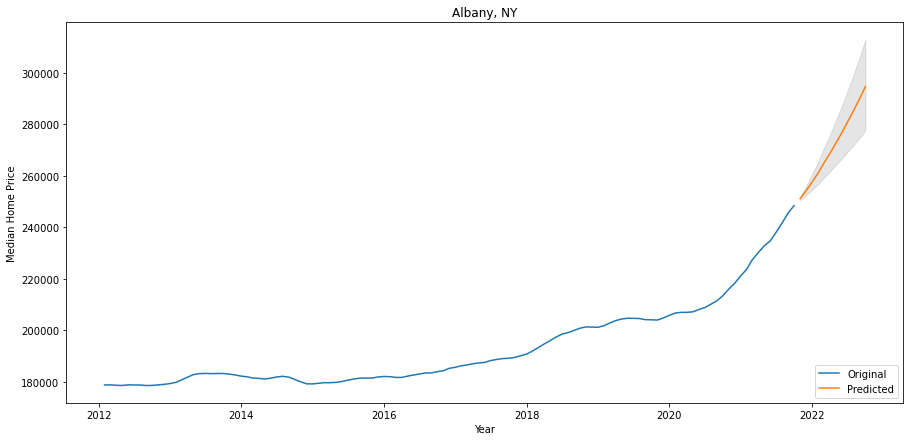

12 month forecast: 294678
95% confidence that the true future value is between 277510, and 312909


In [80]:
plot_results(3, 12)

In [77]:
i, j, k = run_arima_model(3, 12)

In [78]:
k

"Albany, NY",mean,mean_se,mean_ci_lower,mean_ci_upper
2021-10-31,251173.602910,1.001475,250449.092915,251900.208800
2021-11-30,254138.556845,1.003470,252419.068348,255869.758564
2021-12-31,257539.054734,1.006123,254476.101575,260638.874545
2022-01-31,261063.007540,1.008551,256742.447897,265456.275205
2022-02-28,264717.703081,1.010990,259107.181617,270449.710761
2022-03-31,268510.881137,1.013506,261542.788826,275664.619210
2022-04-30,272450.768914,1.016126,264041.020519,281128.369130
2022-05-31,276546.119715,1.018863,266600.584999,286862.672600
2022-06-30,280806.255129,1.021725,269223.320694,292887.528153
2022-07-31,285241.111110,1.024716,271912.698496,299222.845851
